# 3.2.6 Challenge Random Forest - Credit Data Modeling

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import ensemble
from IPython.display import Image
import pydotplus
import graphviz
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import time
%matplotlib inline

Now that you've learned about random forests and decision trees let's do an exercise in accuracy. You know that random forests are basically a collection of decision trees. But how do the accuracies of the two models compare?

So here's what you should do. Pick a dataset. It could be one you've worked with before or it could be a new one. Then build the best decision tree you can.

Now try to match that with the simplest random forest you can. For our purposes measure simplicity with runtime. Compare that to the runtime of the decision tree. This is imperfect but just go with it.

Hopefully out of this you'll see the power of random forests, but also their potential costs. Remember, in the real world you won't necessarily be dealing with thousands of rows. It could be millions, billions, or even more.

In [2]:
#model for timing trees and forests
start_time = time.time()
print('---%s seconds ---' % (time.time() - start_time))

---4.38690185546875e-05 seconds ---


## Credit Approvals Data Set 

__Source:__ [https://archive.ics.uci.edu/ml/datasets/Credit+Approval]

All attribute names and values have been changed to meaningless symbols to protect the confidentiality of the data

In [3]:
#importing and cleaning data
credit_raw = pd.read_csv('credit_approvals.csv', header=None)
credit_raw[1] = credit_raw[1].map(lambda x: None if x is '?' else float(x))
credit_raw[15] = credit_raw[15].map(lambda x: 1 if x is '+' else 0)
for col in credit_raw:
    credit_raw[col] = credit_raw[col].map(lambda x: None if x is '?' else x)
credit_raw.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,1


In [4]:
#creating df for features
#paring down attributes '5' and '6' to top 3-4 values
credit_raw_abbrev = credit_raw.loc[
    ((credit_raw[5] == 'c') | (credit_raw[5] == 'q')  
     | (credit_raw[5] == 'w')  | (credit_raw[5] == 'i')) 
    & ((credit_raw[6] == 'v') | (credit_raw[6] == 'h') 
       | (credit_raw[6] == 'bb'))]
credit_raw_abbrev.dropna()
features = pd.get_dummies(credit_raw_abbrev[5])
features['0'] = np.where((credit_raw_abbrev[0]=='a'), 1, 0)
features['8'] = np.where((credit_raw_abbrev[8]=='t'), 1, 0)
features['cube_root_2'] = (credit_raw_abbrev[2].dropna())**(1/3)
features['cube_root_7'] = (credit_raw_abbrev[7].dropna())**(1/3)
features['15'] = credit_raw_abbrev[15].dropna()
features.head()

,c,i,q,w,0,8,cube_root_2,cube_root_7,15
0,0,0,0,1,0,1,0.000000,1.077217,1
1,0,0,1,0,1,1,1.646057,1.448631,1
2,0,0,1,0,1,1,0.793701,1.144714,1
3,0,0,0,1,0,1,1.154800,1.553616,1
4,0,0,0,1,0,1,1.778447,1.195819,1


In [5]:
#splitting data into train and test groups 75%, 25%
data_train, data_test, target_train, target_test = train_test_split(
            features.drop('15', 1), features['15'], test_size=0.25)

### Modeling
#### Simple Random Forest = Decision Tree

[0.80392157 0.72       0.82       0.7        0.69387755]
---0.016849756240844727 seconds ---


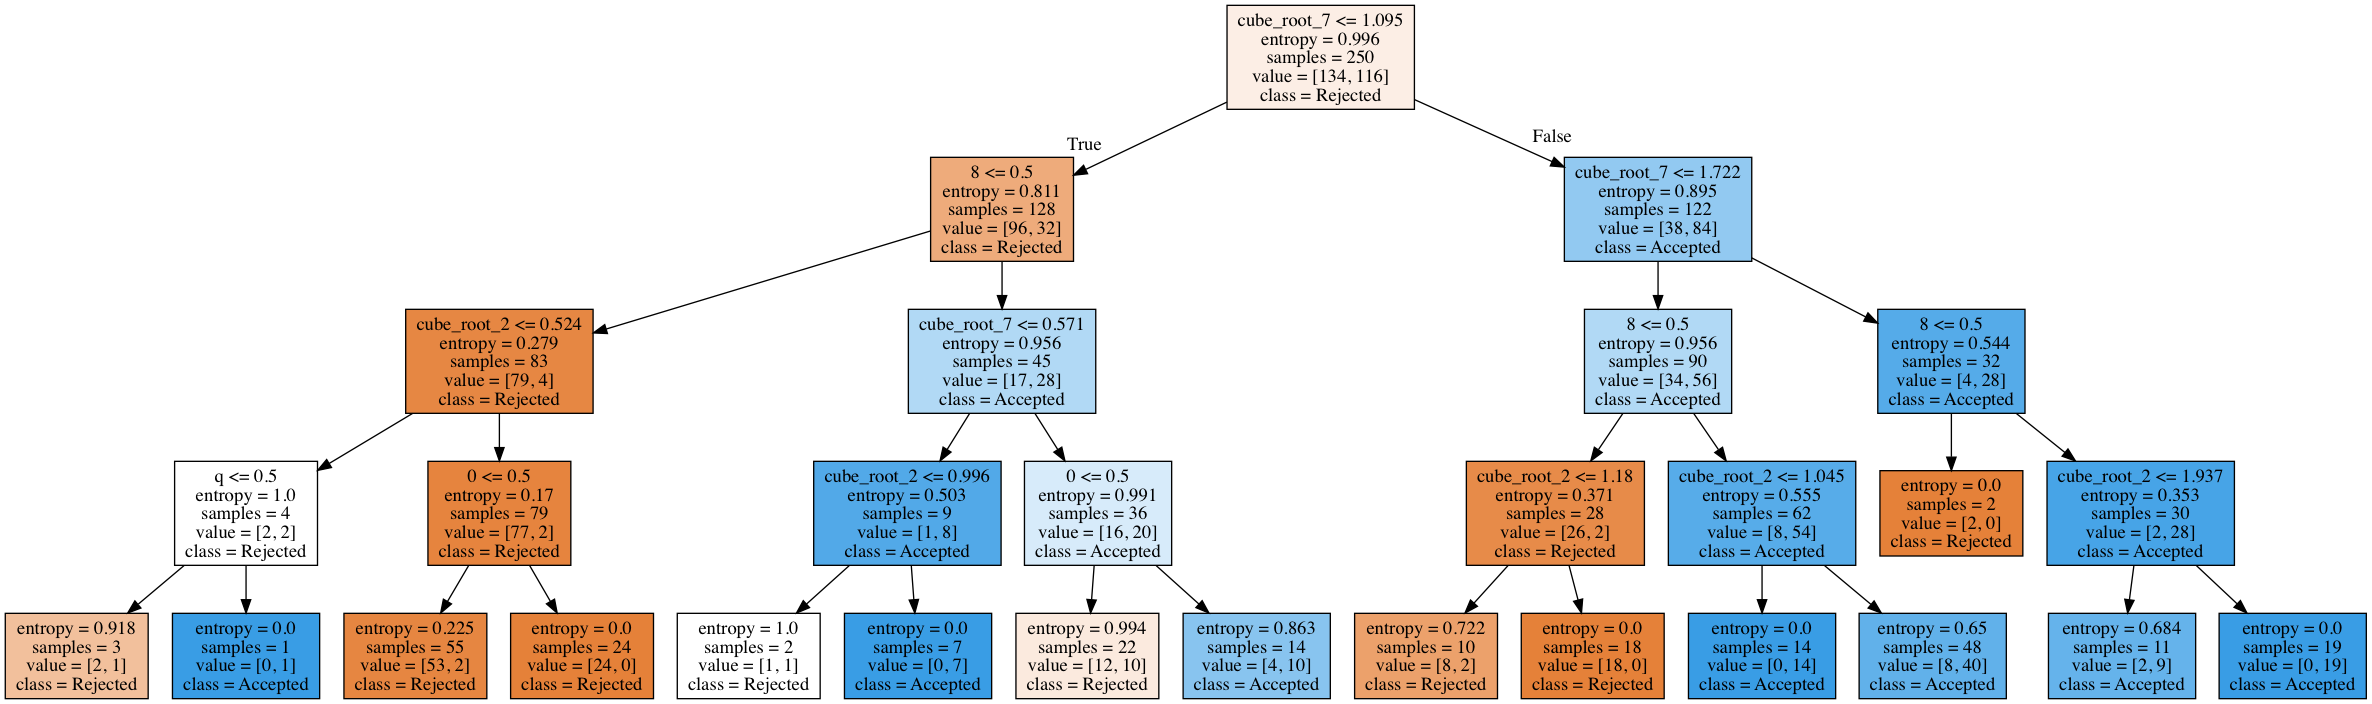

In [6]:
#starting timer
start_time = time.time()

#initialize and train tree
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=3,
    max_depth=4)

decision_tree.fit(data_train, target_train)

print(cross_val_score(decision_tree, data_train, target_train, cv=5))

#ending timer
print('---%s seconds ---' % (time.time() - start_time))

#render tree
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=data_train.columns,
    class_names=['Rejected', 'Accepted'],
    filled=True
)
graph=pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

This tree was created relatively quickly, in only 1.5 tenths of a second.  The accuracy from cross-validation scores were all over the place, from as low as 69% up to 82%. 

## Random Forest

In [7]:
#starting timer
start_time = time.time()

rfc = ensemble.RandomForestClassifier()
rfc.fit(data_train, target_train)
print(cross_val_score(rfc, data_train, target_train, cv=5))

#ending timer
print('---%s seconds ---' % (time.time() - start_time))

[0.82352941 0.82       0.76       0.86       0.7755102 ]
---0.10097098350524902 seconds ---


This took 0.1 seconds, which is about 10 times longer than the single tree.  In this case, the accuracy increased to between 76% and 86%.  This model is still inconsistent in its accuracy, but is more accurate than the single tree.

#### Cross Validation on Test Data

In [8]:
#using tree to predict test data and score
tree_pred = decision_tree.predict(data_test)
tree_score = cross_val_score(decision_tree, data_test, target_test, cv=5).mean()

#using forest to predict test data and score
forest_pred = rfc.predict(data_test)
forest_score = cross_val_score(decision_tree, data_test, target_test, cv=5).mean()

print('Score for Single Tree: {}\nScore for Forest: {}'.format(tree_score, forest_score))

Score for Single Tree: 0.8069444444444445
Score for Forest: 0.7958333333333333


Random Forest was slower, but produced a slightly higher accuracy in predicting outcomes.  The single decision tree had a faster runtime, but had a slightly lower prediction accuracy.  In the future, I'm sure that larger data sets will take longer to run, but especially for a less-complex tree, the forest is worth the computational time spent.